# Dimensionality reduction

fMRI analysis often has a dimensionality problem: we get approximately 100,000 voxels (i.e., features) per volume, but only 100s of time points or trials (i.e., examples). This makes it very hard for machine learning algorithms to model how each voxel contributes, a problem known as the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). For a neuroimaging-specific view on the curse of dimensionality, take a look at [Mwangi et al.'s Neuroinformatics review](https://link.springer.com/article/10.1007/s12021-013-9204-3).

In this notebook we are going to learn various methods that can help us reduce the dimensionality of fMRI data.

## Goal of this script
1. Learn to compute the covariance and correlation of a dataset.  
2. Reduce the feature space using principal component analysis (PCA).  
3. Interpret the meaning of PCA components.  
4. Perform feature selection using cross-validation.  

## Pre-requisites
You should be familiar with the functions in the data loading and classification notebooks.

## Table of Contents
[1. Load the data](#load-data)  

[2. Covariance and correlation](#covariance_and_correlation)   

[3. PCA](#pca)  
>[3.1 Plot PCA](#plot_pca)  
>[3.2 Scree plots](#scree)  
>[3.3 Interpreting components](#cog-relevance)  
>[3.4 Normalization](#pca-norm)  
>[3.5  PCA dimensionality reduction and classification](#wb-pca-class)  

[4. Feature selection](#feat)  
>[4.1 Feature selection: Pipelines](#pipeline)  
>[4.2 Feature selection: Univariate](#univariate)   

Exercises
>[Exercise 1](#ex1)  [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)   [9](#ex9) [10](#ex10)


**Dataset:** For this script we will use a localizer dataset from [Kim et al. (2017)](https://doi.org/10.1523/JNEUROSCI.3272-16.2017) again. Just to recap: The localizer consisted of 3 runs with 5 blocks of each category (faces, scenes and objects) per run. Each block was presented for 15s. Within a block, a stimulus was presented every 1.5s (1 TR) -- we refer to this as a trial. Between blocks, there was 15s (10 TRs) of fixation. Each run was 310 TRs. In the matlab stimulus file, the first row codes for the stimulus category for each trial (1 = Faces, 2 = Scenes, 3 = Objects). The 3rd row contains the time (in seconds, relative to the start of the run) when the stimulus was presented for each trial.



In [1]:
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter('ignore')

# Import neuroimaging, analysis and general libraries
import numpy as np
from time import time
import pandas as pd

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import cross_val_score, cross_validate, PredefinedSplit
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile, RFECV, f_classif
from sklearn.pipeline import Pipeline
np.random.seed(0)
%matplotlib inline

sns.set(palette="colorblind",style = 'white', context='notebook', rc={"lines.linewidth": 2})

In [2]:
# Load some helper functions, which include ones that you wrote last week!
from utils import load_labels, load_data, blockwise_sampling, label2TR, shift_timing, reshape_data
from utils import normalize, decode
# Load some constants
from utils import vdc_data_dir, vdc_all_ROIs, vdc_label_dict, vdc_n_runs, vdc_hrf_lag, vdc_TR, vdc_TRs_run
np.random.seed(0)

print('Here are some constants specific to the VDC data:')
print(f'data dir = {vdc_data_dir}')
print(f'ROIs = {vdc_all_ROIs}')
print(f'Labels = {vdc_label_dict}')
print(f'number of runs = {vdc_n_runs}')
print(f'1 TR = {vdc_TR} sec')
print(f'HRF lag = {vdc_hrf_lag} sec')
print(f'num TRs per run = {vdc_TRs_run}')

Here are some constants specific to the VDC data:
data dir = /gpfs/gibbs/project/cmhn/data/vdc/
ROIs = ['FFA', 'PPA']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects'}
number of runs = 3
1 TR = 1.5 sec
HRF lag = 4.5 sec
num TRs per run = 310


## 1. Load the data <a id="load-data"></a>

Load the data for one participant using these helper functions.

In [3]:
sub_id = 1
mask_name = 'PPA' # This is set in order to reduce memory demands in order to run within 4Gb, however, if you want to make this run on whole brain, then set this to ''

In [4]:
# Specify the subject name
sub = f'sub-{sub_id:02d}' 

# Convert the shift into TRs
shift_size = int(vdc_hrf_lag / vdc_TR)  

# Load subject labels
stim_label_allruns = load_labels(vdc_data_dir, sub)

# Load run_ids
run_ids_raw = stim_label_allruns[5,:] - 1 

# Load the fMRI data using a mask
epi_mask_data_all = load_data(vdc_data_dir, sub, mask_name=mask_name)[0]

# This can differ per participant
print(f'{sub} data has {epi_mask_data_all.shape[1]} TRs and {epi_mask_data_all.shape[0]} voxels')
TRs_run = int(epi_mask_data_all.shape[1] / vdc_n_runs)

# Convert the timing into TR indexes
stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, TRs_run)

# Shift the data some amount
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

# Perform the reshaping of the data
bold_data_raw, labels_raw = reshape_data(stim_label_TR_shifted, epi_mask_data_all)

# Normalize raw data within each run
bold_normalized_raw = normalize(bold_data_raw, run_ids_raw)

# Down sample the data to be blockwise rather than trialwise. 
# We'll use the blockwise data for all the following exercises
bold_data, labels, run_ids = blockwise_sampling(bold_data_raw, labels_raw, run_ids_raw)

# Normalize blockwise data within each run
bold_normalized = normalize(bold_data, run_ids)

Loaded sub-01
Processing Start ...
Loaded PPA mask
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /gpfs/gibbs/project/cmhn/data/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
sub-01 data has 930 TRs and 2504 voxels
Expected blocks: 45; Resampled blocks: 45


<div class="alert alert-block alert-info">
<strong>Block Averaging</strong>
<br>
Previously, we have been using data from each trial. Within each block, the voxel activity is correlated across trials. You should recall from the last notebook and from class that voxel activity follows a hemodynamic response function, which makes it hard to disentangle responses to individual stimuli that are presented close together in time. Thus, it is common (and probably better) to take the average value of the activity within a block as your observation in decoding analyses in order to avoid concerns about non-independence.  Mean values of activity or beta coefficients (from GLM) are commonly used in the literature.
</div>

**Self-study:** We introduce a simple kind of debugging here, as we print both the number of expected and resampled blocks (resampled refers to the conversion from trialwise data to blockwise data). Thus, if something went wrong, we would be able to spot it the output. Learn about more ways of debugging your code by using assertions [here](https://wiki.python.org/moin/UsingAssertionsEffectively).

## 2. Covariance and correlation<a id="covariance_and_correlation"></a>


As a precursor to understanding dimensionality reduction techniques, we need to learn how to compute the covariance matrix because it is often used in these methods.  

By default, we used an PPA mask to reduce the memory demands in this notebook, but if possible we recommend that you use no mask in order to grapple with the memory issues of working with whole brain data. There are nearly 1 million voxels in every volume we acquire, of which about 15% are in the brain. The data matrix of >100,000 voxels and <1000 time points is very large, making any computations on all of this data very intensive.

The covariance of two variables is calculated as follows: $$ Cov(X,Y) = \frac{\sum_{1}^{N}(X-\bar{X})(Y-\bar{Y})}{(N-1)}$$

where $\mbox{  }  \bar{X} = mean(X), \mbox{  } \bar{Y} = mean(Y), \mbox{  } N = \mbox{number of samples } $
 
 
In fMRI, X and Y could be time-series data for two voxels (two columns in our time by voxels data matrix) or the pattern across voxels for two different time points (two rows in the data matrix). The choice of vectors depends on the application.

**Exercise 1:** <a id="ex1"></a> Choose any two blocks and compute the covariance between their activation patterns. The steps to do this are outlined below. You could just use a function but we want you to code the individual steps as described (refer [here](https://numpy.org/doc/stable/reference/generated/numpy.cov.html) for additional help).


In [5]:
# Choose which blocks you will compare.
block_i = bold_data[1]
block_j = bold_data[12]
# Create an array X that corresponds with block_i. Compute the mean of X.
X = np.array(block_i)
Xmean = np.mean(X)
# Create an array Y that corresponds with block_j. Compute the mean of Y.
Y = np.array(block_j)
Ymean = np.mean(Y)
# Compute the difference of the individual voxels in X and the mean of X. 
Xdiff = X - Xmean
# Compute the difference of the individual voxels in Y and the mean of Y. 
Ydiff = Y - Ymean
# Compute the pointwise product of the difference vectors across the two rows.
pointwiseProduct = np.multiply(Xdiff, Ydiff)
# Sum over the products of the differences.
Sum = np.sum(pointwiseProduct)
# Divide by the number of voxels minus 1 and save the result in a variable called my_cov.
my_cov = Sum / (bold_data.shape[1] - 1)

print(my_cov)
# Compare your result to the answer obtained with np.cov(X,Y) by uncommenting the below line.
# Note that the output of np.cov will be a 2 by 2 array because it will do all pairwise comparisons of the X and Y variables supplied (including self with self).
# So, the elements of that array represent [[np.cov(X,X), np.cov(X,Y)], [np.cov(Y,X), np.cov(Y,Y)]]. 
# Compare your result with only the element in the array corresponding with cov(X, Y).

# UNCOMMENT BELOW: 
print(np.cov(X,Y)[0,1])
print(np.isclose(my_cov , np.cov(X,Y)[0,1]))


1580707.0659576189
1580707.0659576182
True


Covariance is dependent on the unit and scale of the measurement. Thus, its value isn't easily interpretable or comparable across datasets -- e.g. is there a strong relationship between X and Y if the covariance is 200 as compared to 2 or 2000?

Correlation solves this problem by normalizing the range of the covariance from -1 to +1 by dividing the covariance by the product of the standard deviations of X and Y.

$$ Corr(X,Y) = \frac{Cov(X,Y)}{\sqrt{\frac{\sum_{1}^{N}(X-\bar{X})^2}{(N-1)}}\sqrt{\frac{\sum_{1}^{N}(Y-\bar{Y})^2}{(N-1)}}}$$

**Exercise 2:** <a id="ex2"></a> Compute the correlation between all pairs of blocks manually (one pair at a time) and compare the result with a numpy function that calculates the block-by-block correlation matrix in one step. Visualize the correlation matrices using imshow.

In [6]:
# Compute the correlation manually and save in a variable called my_corrmat.
def cov(x,y):
    fblock_a = bold_data[x]
    fblock_b = bold_data[y]

    fX = np.array(fblock_a)
    fXmean = np.mean(fX)

    fY = np.array(fblock_b)
    fYmean = np.mean(fY)

    fXdiff = fX - fXmean

    fYdiff = fY - fYmean

    fpointwiseProduct = np.multiply(fXdiff, fYdiff)

    fSum = np.sum(fpointwiseProduct)

    return(fSum / (bold_data.shape[1] - 1))

my_corrmat = np.empty((45 , 45))

for i in range(45):
    for j in range(45):
        my_corrmat[i,j] = (cov(i,j)) / (np.std(bold_data[i]) * np.std(bold_data[j]))
        
print(my_corrmat)
print("_________________________________________")
# Now with a numpy function.
# Compute the correlation matrix with a numpy function, save it in a variable corrmat_numpy,
# and compare your result. 

corrmat_numpy = np.corrcoef(bold_data)
print(corrmat_numpy)
print("_________________________________________")
# UNCOMMENT BELOW:
# print(np.allclose(my_corrmat , corrmat_numpy))
print(np.abs(my_corrmat - corrmat_numpy))

[[1.00039952 0.99628333 0.99655905 ... 0.96554755 0.96728805 0.96766695]
 [0.99628333 1.00039952 0.99557072 ... 0.96615724 0.96689003 0.96757436]
 [0.99655905 0.99557072 1.00039952 ... 0.96570149 0.96704585 0.96731426]
 ...
 [0.96554755 0.96615724 0.96570149 ... 1.00039952 0.99491625 0.99564555]
 [0.96728805 0.96689003 0.96704585 ... 0.99491625 1.00039952 0.99633091]
 [0.96766695 0.96757436 0.96731426 ... 0.99564555 0.99633091 1.00039952]]
_________________________________________
[[1.         0.99588545 0.99616106 ... 0.96516194 0.96690175 0.9672805 ]
 [0.99588545 1.         0.99517312 ... 0.96577139 0.96650389 0.96718794]
 [0.99616106 0.99517312 1.         ... 0.96531583 0.96665965 0.96692795]
 ...
 [0.96516194 0.96577139 0.96531583 ... 1.         0.99451892 0.99524792]
 [0.96690175 0.96650389 0.96665965 ... 0.99451892 1.         0.99593301]
 [0.9672805  0.96718794 0.96692795 ... 0.99524792 0.99593301 1.        ]]
_________________________________________
[[0.00039952 0.00039788 0.00

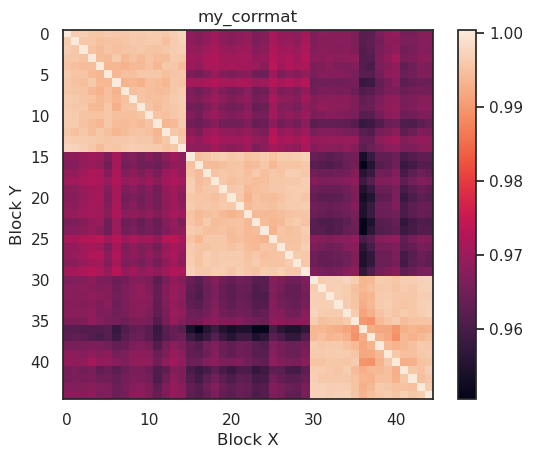

In [7]:
# Visualize the matrices, including colorbars, axis labels, and plot titles.

plt.imshow(my_corrmat)
plt.ylabel('Block Y')
plt.xlabel('Block X')
plt.title("my_corrmat")
plt.colorbar()

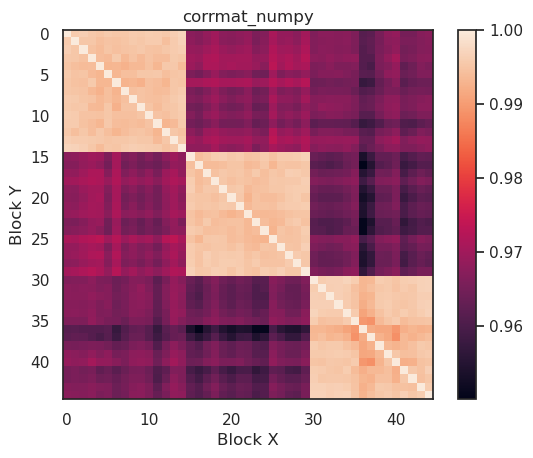

In [8]:
plt.imshow(corrmat_numpy)
plt.ylabel('Block Y')
plt.xlabel('Block X')
plt.title("corrmat_numpy")
plt.colorbar()

**Exercise 3**: <a id="ex3"></a> Now we will calculate covariance and correlation between block-wise timeseries rather than activation patterns. Use `np.cov` to compute the covariance between average block activation over time from pairs of voxels and `np.corrcoef` to compute their correlation. Perform this computation on a subset of 500 voxels (all possible pairs) to make 1) a voxel-by-voxel covariance matrix and 2) a voxel-by-voxel correlation matrix. Each matrix must be computed in one step (no `for` loops allowed). Visualize these matrices, each with a colorbar. Make sure the matrices are the right shape (500 by 500). 

<function matplotlib.pyplot.show(close=None, block=None)>

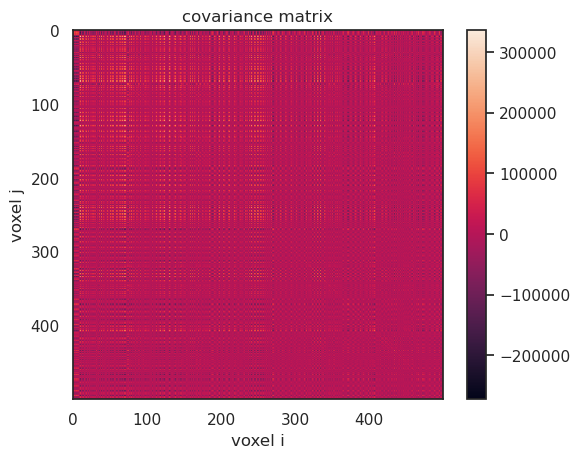

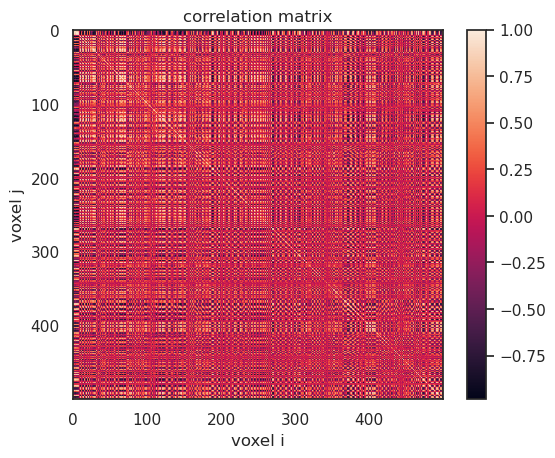

In [9]:
# Insert code

# Subselect 500 voxels from bold_data into a matrix.
vox_matrix = bold_data[:, :500].transpose()
# Use np.cov() to compute the covariance between timeseries.
cov_matrix = np.cov(vox_matrix)
# Use np.corrcoef() to compute the correlation between timeseries.
corr_matrix = np.corrcoef(vox_matrix)
# Visualize the matrices, including colorbars, axis labels, and plot titles.

fig, ax = plt.subplots()
ax.set_title("covariance matrix")
ax.set_xlabel("voxel i")
ax.set_ylabel("voxel j")
image = ax.imshow(cov_matrix)
fig.colorbar(image, ax=ax)


fig, ax = plt.subplots()
ax.set_title("correlation matrix")
ax.set_xlabel("voxel i")
ax.set_ylabel("voxel j")
image = ax.imshow(corr_matrix)
fig.colorbar(image, ax=ax)

plt.show

## 3. PCA <a id="pca"></a>

We will use principal component analysis (PCA) to **reduce the dimensionality** of the data. Some voxels may contain correlated information or no information and so the original voxel-dimensional data matrix (time-by-voxels) can be projected into a lower-dimensional "component" matrix space (time-by-component) without losing much information.

![image](https://cdn-images-1.medium.com/max/1200/1*Iri_LDMXuz2Qac-8KPeESA.png)

In [10]:
# Use the PCA function in scikit-learn to reduce the dimensionality of the data.
# The number of components was chosen arbitrarily.

n_components = 20
pca = PCA(n_components = n_components)
bold_pca = pca.fit_transform(bold_data)

print(f'Original data shape: {bold_data.shape}')
print(f'PCA data shape: {bold_pca.shape}')

Original data shape: (45, 2504)
PCA data shape: (45, 20)


### 3.1 Plot PCA <a id="plot_pca"></a>

Let's visualize the variance in the data along different component dimensions.

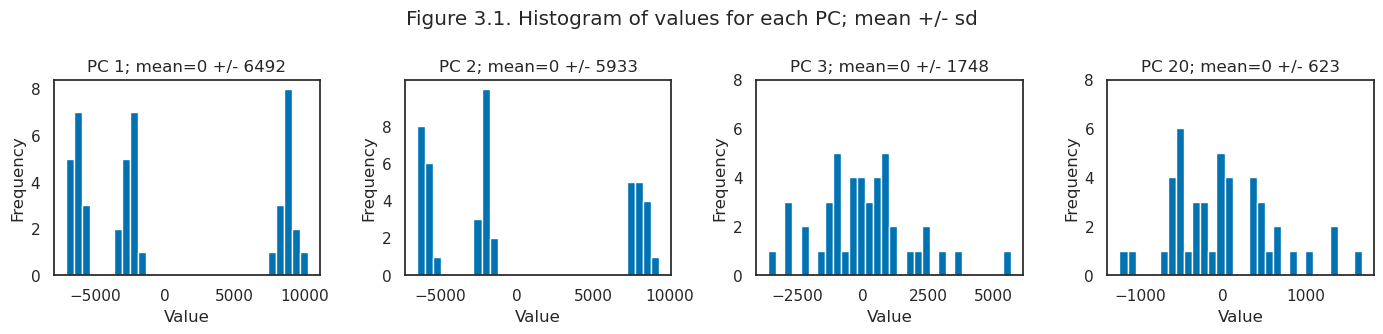

In [11]:
# Setting plotting parameter
n_bins=30

# Plot
n_plots = 4
components_to_plot = [0,1,2,19]
f, ax = plt.subplots(1, n_plots, figsize=(14, 14/n_plots))
st=f.suptitle("Figure 3.1. Histogram of values for each PC; mean +/- sd", fontsize="large")

for i in range(n_plots): 
    data = bold_pca[:, components_to_plot[i]]
    ax[i].hist(data, bins=n_bins)
    # Mark the plots 
    ax[i].set_title(f'PC {components_to_plot[i]+1}; mean={int(np.mean(data))} +/- {int(np.std(data))}')
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Value')  
    ax[i].set_yticks(np.arange(0,10,2))    

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)

Let's visualize the relationship between variances across pairs of components.

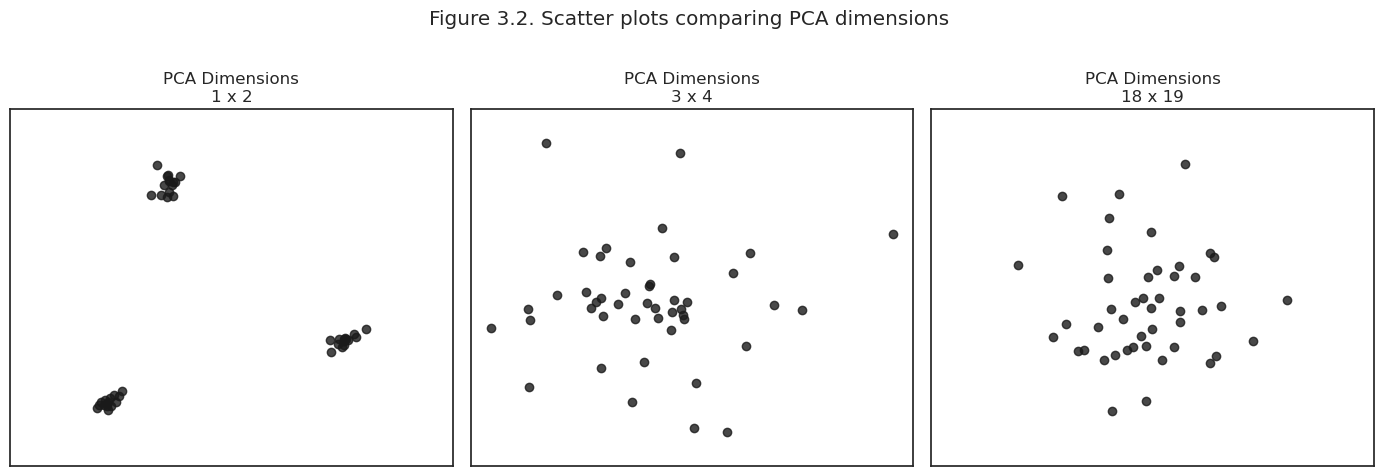

In [12]:
"""
Plot the low dim representation of the bold data
"""
# Setting plotting parameters
alpha_val = .8
cur_pals = sns.color_palette('colorblind', n_colors=vdc_n_runs)
c = 'k'
# Plot
n_plots = 3 
f, ax = plt.subplots(1, n_plots, figsize=(14,5))
st=f.suptitle("Figure 3.2. Scatter plots comparing PCA dimensions ", fontsize="large")

# Plot data
ax[0].scatter(bold_pca[:, 0], bold_pca[:, 1], 
                alpha=alpha_val, marker='o', c=c)
ax[1].scatter(bold_pca[:, 2], bold_pca[:, 3], 
                alpha=alpha_val, marker='o', c=c)
ax[2].scatter(bold_pca[:, 18], bold_pca[:, 19], 
                alpha=alpha_val, marker='o', c=c)

ax[0].set_title('PCA Dimensions\n1 x 2')
ax[1].set_title('PCA Dimensions\n3 x 4')
ax[2].set_title('PCA Dimensions\n18 x 19')

# Mdodifications that are common to all plots 
for i in range(n_plots): 
    ax[i].axis('equal')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)


### 3.2 Scree plots <a id="scree"></a>

A ["scree" plot](https://www.statology.org/scree-plot-python) can depict the amount of variance in the original data that is explained by each component.

**Exercise 4:** <a id="ex4"></a> Make a scree plot for `pca` above. 

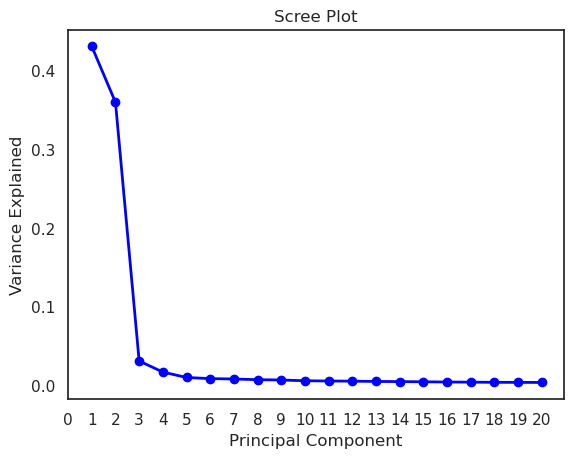

In [13]:
# Insert code here
import matplotlib.pyplot as plt
import numpy as np

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(21))
plt.show()

**Exercise 5:** <a id="ex5"></a> How many components would account for at least 80% of the variance in the data? 

In [14]:
# Insert code here
variancePercent = 0.00
for i in range(len(PC_values)):
    variancePercent = variancePercent + pca.explained_variance_ratio_[i]
    if variancePercent > 0.80:
        print(i + 1)
        break

3


**A:** 

3 components

### 3.3 Interpreting Components  <a id="cog-relevance"></a>

From the previous plot of the first and second PCA dimension, you can see you have three clusters. You might assume that they correspond to faces, scenes, and objects.

**Exercise 6:**  <a id="ex6"></a> What do the three clusters correspond to? Explore this with a new scatterplot, where you visualize the first two components and mark the stimulus category in different colors. Does that explain the clusters? If not, create a second scatter plot with points labeled in a way that better corresponds to the clusters (complete this exercise before reading further). (_Hint 1_: What else was there three of? _Hint 2_: Look back at the data handling notebook.)

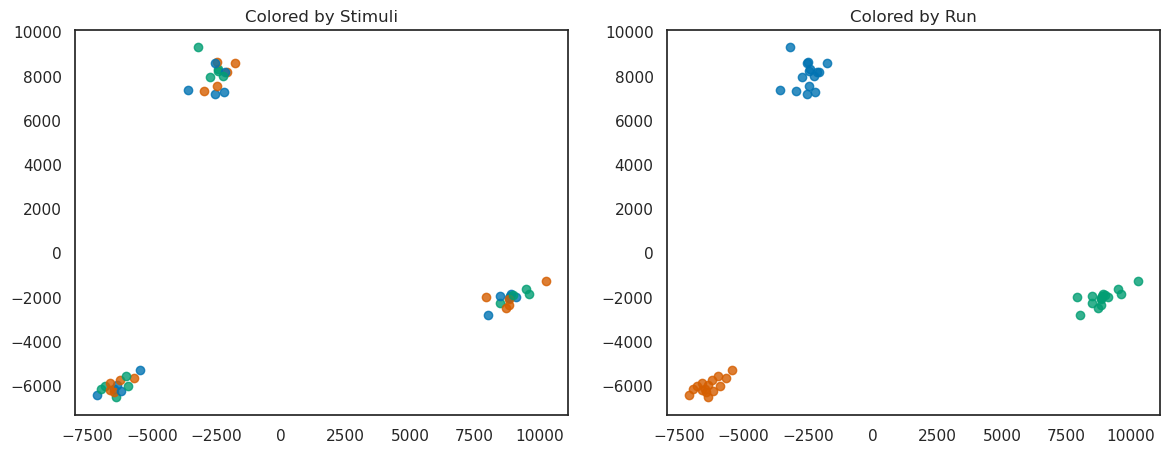

In [15]:
# Insert code here
f, ax = plt.subplots(1, 2, figsize=(14,5))
colors = ["r", "g", "b"]
for i in range(0,45):
        c = colors[int(labels[i]-1)]
        ax[0].scatter(bold_pca[i,0], bold_pca[i,1], alpha=alpha_val, marker="o", c=c)
        ax[0].set_title('Colored by Stimuli')
for i in range(0,45):
        c = colors[int(run_ids[i]-1)]
        ax[1].scatter(bold_pca[i,0], bold_pca[i,1], alpha=alpha_val, marker="o", c=c)
        ax[1].set_title('Colored by Run')

**A:**   
The three clusters correspond to the three different runs, implying data needs to be normalized.

### 3.4 Normalization <a id="pca-norm"></a>

The previous exercise revealed our error: we ran PCA on the data before normalizing it. 

**Exercise 7:**<a id="ex7"></a> Using the variable `bold_normalized`, re-compute the PCA (components=20). Plot the results with a scatter plot like **Figure 3.2**, displaying dimensions 1x2, 3x4, and 18x19 (remembering to account for python indexing!), but use colors or symbols to mark points on the plot by stimulus category. What was the effect of normalization? Why is this useful?  

In [16]:
# Insert code here
n_components = 20
pca = PCA(n_components = n_components)
bold_pca = pca.fit_transform(bold_normalized)

print(f'Original data shape: {bold_normalized.shape}')
print(f'PCA data shape: {bold_pca.shape}')

Original data shape: (45, 2504)
PCA data shape: (45, 20)


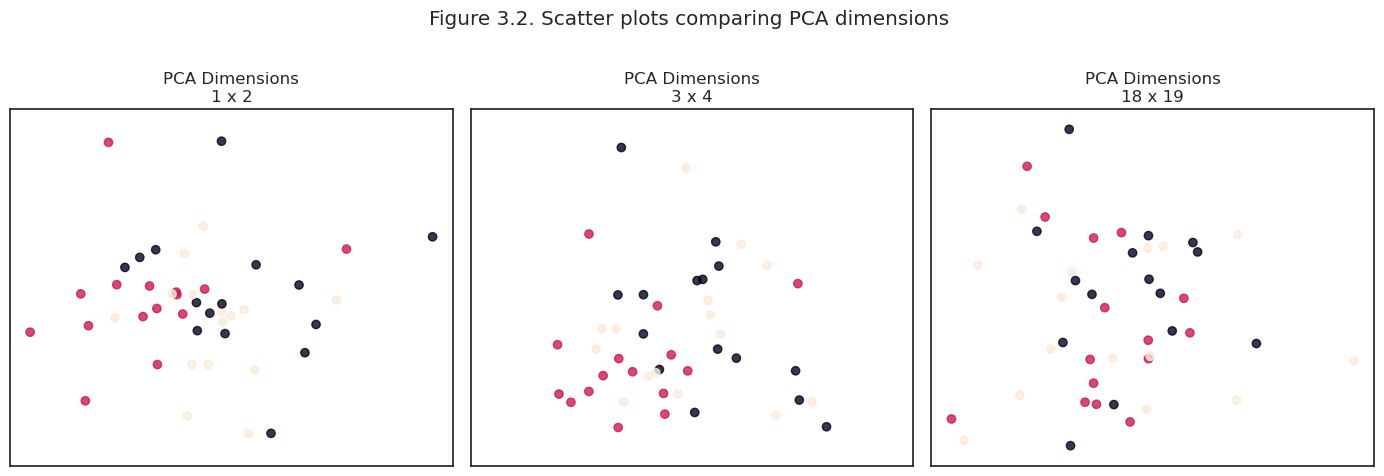

In [17]:

"""
Plot the low dim representation of the bold data
"""


        
# Setting plotting parameters
alpha_val = .8
cur_pals = sns.color_palette('colorblind', n_colors=vdc_n_runs)
c = 'k'
# Plot
n_plots = 3 
f, ax = plt.subplots(1, n_plots, figsize=(14,5))
st=f.suptitle("Figure 3.2. Scatter plots comparing PCA dimensions ", fontsize="large")

# Plot data

ax[0].scatter(bold_pca[:, 0], bold_pca[:, 1], alpha=alpha_val, marker='o', c=labels)

ax[1].scatter(bold_pca[:, 2], bold_pca[:, 3], alpha=alpha_val, marker='o', c=labels)

ax[2].scatter(bold_pca[:, 18], bold_pca[:, 19], alpha=alpha_val, marker='o', c=labels)

ax[0].set_title('PCA Dimensions\n1 x 2')
ax[1].set_title('PCA Dimensions\n3 x 4')
ax[2].set_title('PCA Dimensions\n18 x 19')

# Mdodifications that are common to all plots 
for i in range(n_plots): 
    ax[i].axis('equal')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

f.tight_layout()
st.set_y(0.95)
f.subplots_adjust(top=0.75)

**A:**  
From the normalization, we get rid of uninteresting variance caused by inconsistencies between runs. By normalizing within each run first, we can see the actual differences between brain activity under different stimuli for each component. This normalization got rid of uninteresting variance caused by confounding voxel intensity differences between runs.

<div class="alert alert-block alert-warning">
<strong>Aside:</strong> This exercise should have revealed to you an important point in fMRI analyses: a large portion of variance in your data can be the result of some uninteresting secondary effect (in this case, run-wise differences). So, just because it might "make sense" that we saw three clusters, given that we had three stimulus categories, it's important to visualize your data in multiple different ways (for instance, marking by stimulus category) to make sure that the thing you think is driving an effect is indeed driving the effect!
</div>

### 3.5 PCA dimensionality reduction and classification <a id="wb-pca-class"></a>
As mentioned earlier, we use PCA to reduce the dimensionality of the data and thus minimize the 'curse of dimensionality'. Below we explore how PCA affects classification accuracy.

In [18]:
# Run a basic n-fold classification

# Get baseline, whole-brain decoding accuracy without PCA
print('Baseline classification:')
print('Original size: ', bold_normalized.shape)
svc = SVC(kernel="linear", C=1)
start = time()
models, scores = decode(bold_normalized, labels, run_ids, svc)
end = time()
print(f'Accuracy: {np.mean(scores)}')
print(f'Run time: {end - start}')

Baseline classification:
Original size:  (45, 2504)
Accuracy: 0.7111111111111111
Run time: 0.010936498641967773


In [19]:
# Run the classifier on data in component space 
pca = PCA(n_components=20)
bold_pca_normalized = pca.fit_transform(bold_normalized)
print('PCA (c=%d) classification' % bold_pca_normalized.shape[1])
print('New size after PCA: ', bold_pca_normalized.shape)
svc = SVC(kernel="linear", C=1)
start = time()
models_pca, scores_pca = decode(bold_pca_normalized, labels, run_ids, svc)
end = time()
print(f'Accuracy: {np.mean(scores_pca)}')
print(f'Run time: {end - start}')

PCA (c=20) classification
New size after PCA:  (45, 20)
Accuracy: 0.7999999999999999
Run time: 0.003971099853515625


In this case PCA does not improve decoding accuracy that much. However, note that similar performance was achieved with 20 vs. 2504 features, that the analysis ran 30x faster, and that the resulting model is likely to generalize better to new data (e.g., from a different subject).

**Exercise 8:** <a id="ex8"></a> Earlier we mentioned that 20 components was arbitrary. How does decoding accuracy change with greater or fewer components? Test it on 1 to 45 components.

Text(0, 0.5, 'Decoding Accuracy')

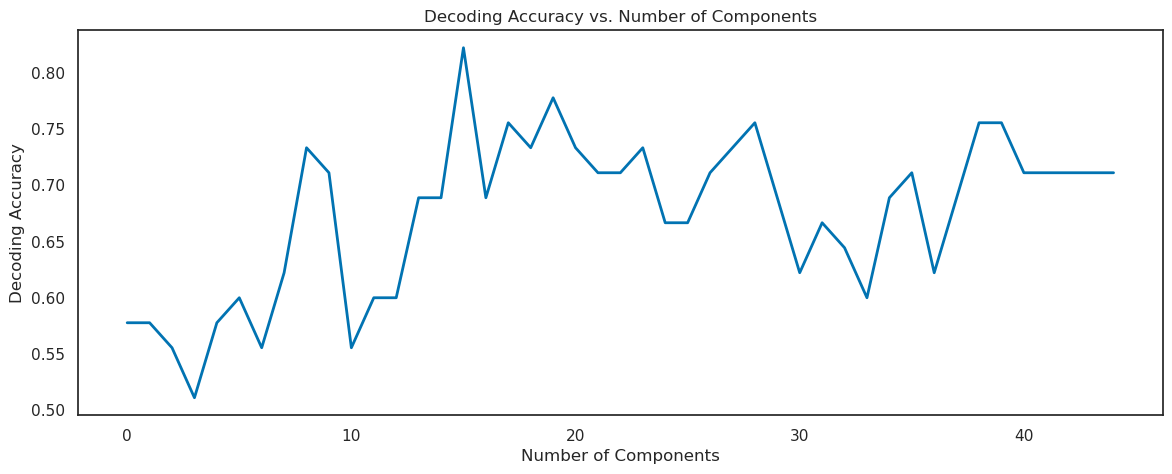

In [20]:
# Insert code here
np.random.seed(0)
# Run the classifier on data in component space
scoresArray = np.zeros(45)
for i in range(1,46):
    pca = PCA(n_components=i)
    bold_pca_normalized = pca.fit_transform(bold_normalized)
    svc = SVC(kernel="linear", C=1)
    start = time()
    models_pca, scores_pca = decode(bold_pca_normalized, labels, run_ids, svc)
    end = time()
    scoresArray[i-1] = np.mean(scores_pca)

    
f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(scoresArray)

ax.set_title('Decoding Accuracy vs. Number of Components')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Decoding Accuracy')

**A:** 
in general, mid to high numbers of components have higher accuracy than a very low number of components but the accuracy is highly variable.

**Exercise 9:** <a id="ex8"></a> What is the smallest number of components you could use to get the maximum accuracy?



In [21]:
# Insert code here
maxacc = np.max(scoresArray)
for i in range(len(scoresArray)):
    if scoresArray[i] == maxacc:
        print(i)
        break

15


You need at least 15 components to get the max accuracy

## 4. Feature selection using cross-validation <a id="feat"></a>

When we took a few PCA components instead of all voxels, we were performing feature selection. Feature selection is used to reduce noise and increase computational speed. However, a problem with the PCA approach above is that feature selection is applied to all data (prior to division into training and test sets) and is thus a kind of double dipping.

A better way to select features is during cross-validation. In this case, feature selection is only performed on the training set, and the same features are used on the test data. This way the classifier never sees the test data during training.

<div class="alert alert-block alert-warning">
<strong>Aside:</strong>  While doing PCA on the whole dataset violates the principle of “never touch your test data during training”, researchers have sometimes used this approach, justifying it on the grounds that — while PCA is using the fMRI data from the test set — it is not peeking at the class labels from the test set, and thus it will not bias classification accuracy. Is this OK? It’s difficult to say *a priori*. It is always safer to completely avoid touching the test data during training, so you should do this if at all possible. If you aren’t sure what problems might emerge from a particular analysis method, a good check of your method is to test on random noise; when you do this, classification should not exceed chance (if it does, you have a problem…)
</div>

We will perform feature selection during cross-validation in this section. The `Pipeline` method in scikit-learn provides an easy interface to perform these steps and we will use it extensively.



### 4.1 Pipelines: Feature selection with cross-validation  <a id="pipeline"></a>

The scikit-learn has a method called [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) that simplifies running a sequence of steps in an automated fashion. Below we create a pipeline with the following steps:
  
>Perform dimensionality reduction.  
>Run an SVM.

To do this systematically during cross-validation, we will embed `Pipeline` in the `cross_validate` method in scikit-learn.

The steps below are based on [this example in scikit-learn](https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#illustration-of-pipeline-and-gridsearchcv).

In [22]:
# Example: 

# Set up the pipeline
pipe = Pipeline([
    ('reduce_dim', PCA(n_components=20)),
    ('classify', SVC(kernel="linear", C=1)),
])

# Run the pipeline with cross-validation
ps = PredefinedSplit(run_ids) # Provides train/test indices to split data in train/test sets
clf_pipe = cross_validate(
    pipe,bold_normalized,labels,cv=ps,
    return_train_score=True
)

# Print results from this dimensionality reduction technique
print(clf_pipe)
print ("Average Testing Accuracy: %0.2f" % (np.mean(clf_pipe['test_score'])))

{'fit_time': array([0.0122931 , 0.01207185, 0.01192331]), 'score_time': array([0.00091958, 0.00084615, 0.00085258]), 'test_score': array([0.73333333, 0.73333333, 0.66666667]), 'train_score': array([1., 1., 1.])}
Average Testing Accuracy: 0.71


Print out the data indices that were used for training and testing. Ensure that they are different for each fold. 

In [23]:
# Print train/test split
for cv_idx ,(train_index, test_index) in enumerate(ps.split(bold_normalized, labels)):
    print('CV iteration: %s' % cv_idx)
    print(f'Train_index: {train_index} ')
    print(f'Test_index: {test_index}')

# Print results from this dimensionality reduction technique
print(clf_pipe)
print (f"Average Testing Accuracy: {np.mean(clf_pipe['test_score'])}")

CV iteration: 0
Train_index: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44] 
Test_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
CV iteration: 1
Train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44] 
Test_index: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
CV iteration: 2
Train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] 
Test_index: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
{'fit_time': array([0.0122931 , 0.01207185, 0.01192331]), 'score_time': array([0.00091958, 0.00084615, 0.00085258]), 'test_score': array([0.73333333, 0.73333333, 0.66666667]), 'train_score': array([1., 1., 1.])}
Average Testing Accuracy: 0.7111111111111111


### 4.2 Feature selection: Univariate <a id="univariate"></a>

We can also use a variety of univariate methods to do feature selection in scikit-learn. One commonly used technique is to compute an ANOVA on the data and pick voxels with large F values. The F value measures the ratio of the variance between conditions (signal) to the variance within condition (noise). You can learn more about the ANOVA here:  [ANOVA F-value](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html). Note that implementing this completely different feature selection approach requires changing only one line in the pipeline, demonstrating the usefulness of this framework.

**Exercise 10:** <a id="ex10"></a> Implement the pipeline using ANOVA F-value (imported as `f_classif`) and the [`SelectPercentile` method](http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) to pick the top 10% of voxels with the highest F values.

In [24]:
# Insert code here
pipe1 = Pipeline([('f_classif', SelectPercentile(f_classif, percentile=10)), ('classify', SVC(kernel="linear", C=1))])

ps1 = PredefinedSplit(run_ids) # Provides train/test indices to split data in train/test sets
clf_pipe1 = cross_validate(
    pipe1,bold_normalized,labels,cv=ps,
    return_train_score=True
)

# Print results from this dimensionality reduction technique
print(clf_pipe1)
print ("Average Testing Accuracy: %0.2f" % (np.mean(clf_pipe1['test_score'])))

{'fit_time': array([0.00381231, 0.00341344, 0.00347114]), 'score_time': array([0.00090885, 0.00090241, 0.00089431]), 'test_score': array([0.86666667, 0.8       , 0.73333333]), 'train_score': array([1., 1., 1.])}
Average Testing Accuracy: 0.80


**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization. 

In [25]:
# Put novel contribution here
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

pipe2 = Pipeline([('f_classif', SelectPercentile(f_classif, percentile=10)), ('classify', GaussianNB())])

ps2 = PredefinedSplit(run_ids) # Provides train/test indices to split data in train/test sets
clf_pipe2 = cross_validate(
    pipe2,bold_normalized,labels,cv=ps,
    return_train_score=True
)

# Print results from this dimensionality reduction technique
print(clf_pipe2)
print ("Average Testing Accuracy: %0.2f" % (np.mean(clf_pipe2['test_score'])))

{'fit_time': array([0.00366068, 0.00347781, 0.00358367]), 'score_time': array([0.00113273, 0.00101519, 0.00102043]), 'test_score': array([0.8       , 0.66666667, 0.8       ]), 'train_score': array([0.96666667, 1.        , 0.96666667])}
Average Testing Accuracy: 0.76


Gaussian Naive Bayes had slightly worse but comparable classification accuracy.

## Contributions <a id="contributions"></a>

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook  02/2018  
T. Meissner minor edits and added the ICA section  
Q. Lu revise PCA plots, cb colors, code style improvement, leverage exisiting funcs  
H. Zhang added pipeline section, use blockwise normalized data, other edits  
M. Kumar enhanced section introductions.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis implemented comments from cmhn-s19    
A.K. Sahoo fixed broken links and did minor edits.   
T. Yates made edits for cmhn_s21  
E. Busch edits for cmhn_s22, cmhn_s23